Collected dataset from CPCB air quality index(Monitering stations).

Bihar ----> 38 stations data for 1 year(2023) with temporal resolution of 30 min for 2 pollutants (PM2.5 and O3).


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from geopy.distance import geodesic

**Pre-processing**

**Merging alll the downloaded Files**

In [ ]:
# Folder containing your files
folder_path = "/content/drive/MyDrive/ML_Project/Bihar_Pm2.5_xlsx"

# Initialize an empty list to store dataframes
dataframes = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".xlsx"):  # assuming Excel files
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Check for the presence of required columns
        df = pd.read_excel(file_path, nrows=0)  # Read only header row for column check
        if 'From Date' in df.columns and 'To Date' in df.columns:
            # If both columns are present, read the file with date parsing
            df = pd.read_excel(file_path, parse_dates=['From Date', 'To Date'])

            # Rename columns to standardize across files if necessary
            df.rename(columns={'From Date': 'DateTime'}, inplace=True)

            # Append the dataframe to the list
            dataframes.append(df)
        else:
            print(f"Skipping file {filename} - missing 'From Date' or 'To Date' columns.")

# Merge all files on the 'DateTime' column using an outer join
if dataframes:
    combined_df = pd.concat(dataframes, axis=0).groupby('DateTime', as_index=False).first()

    # Save combined data to a new file in the same folder
    combined_file_path = os.path.join(folder_path, "Bihar_PM2.5(2023).csv")
    combined_df.to_csv(combined_file_path, index=False)
    print(f"Files combined successfully into {combined_file_path}")
else:
    print("No files were combined due to missing required columns.")


**Dropping 'To Date' column and assigning id to stations**

In [ ]:
file_path = '/content/drive/MyDrive/ML_Project/Bihar_csv/Bihar_O3(2023).csv'
df = pd.read_csv(file_path)

# Drop 'To Date' column
df = df.drop(columns=['To Date'])

# Rename station columns as 0, 1, 2, ...
# Start renaming from the third column (index 2) to avoid 'DateTime'
station_columns = df.columns[1:]  # Select station columns
new_names = {old_name: str(i) for i, old_name in enumerate(station_columns)}
df = df.rename(columns=new_names)

# Save the modified DataFrame to the same file path, overwriting the original file
df.to_csv(file_path, index=False)

print("File updated successfully.")


**Converting Short format File into Long format which is suitable for Modelling**

In [ ]:
# Load the CSV file
file_path = "/content/drive/MyDrive/ML_Project/Bihar_csv/Bihar_PM2.5(2023).csv"
df = pd.read_csv(file_path)

# Reshape the data using `melt`
df_long = pd.melt(df, id_vars=['DateTime'],
                  value_vars=[str(i) for i in range(38)],
                  var_name='Stn_id',
                  value_name='Pm2.5')

# Save the modified file
output_file_path = "/content/drive/MyDrive/ML_Project/Bihar_csv/Reshaped_Bihar_PM2.5(2023).csv"
df_long.to_csv(output_file_path, index=False)

print(f"Reshaped file saved as {output_file_path}")


**Interpolating the Dataset using Polynomial interpolation**

In [ ]:
input_file = "/content/drive/MyDrive/ML_Project/Bihar_csv/Reshaped_Bihar_Pm2.5(2023).csv"  # Replace with your file path
output_file = "/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_pollutant_data_Pm2.5_interpolated.csv"  # New file for saving results

# Read the melted data
data = pd.read_csv(input_file)

# Function to perform polynomial interpolation on a columnA
def interpolate_polynomial(column, degree=2):

    x = column.dropna().index.values  # Indices of known values
    y = column.dropna().values       # Known values

    # Skip interpolation if insufficient points
    if len(x) <= degree:
        return column  # Return original column if interpolation can't be applied

    # Fit polynomial to known points
    poly_fit = np.polyfit(x, y, degree)A
    poly = np.poly1d(poly_fit)

    # Generate interpolated values
    interpolated_values = column.copy()
    missing_x = column.index[column.isna()]
    interpolated_values[missing_x] = poly(missing_x)

    return interpolated_values

# Apply interpolation group-wise and reset the index alignment
data["O3"] = (
    data.groupby("Stn_id", group_keys=False)["O3"]
    .apply(lambda col: interpolate_polynomial(col))
)

# Save the interpolated data to a new CSV file
data.to_csv(output_file, index=False)

print(f"Interpolated data saved to {output_file}")


**removing the station which has complete null values**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_pollutant_data_PM2.5_interpolated.csv')

null_o3_stn_ids = data[data['Pm2.5'].isnull()]['Stn_id'].unique()

# Drop rows with these Stn_ids
cleaned_data = data[~data['Stn_id'].isin(null_o3_stn_ids)]

# Save the cleaned dataset to a new file
cleaned_data.to_csv('/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_Cleaned_PM2.5_interpolated.csv', index=False)

print("Rows with Stn_id(s) {} have been removed and saved to 'cleaned_file.csv'.".format(null_o3_stn_ids))

**Merging the file with file that has lat and lon for each station**

In [ ]:
# Load the two CSV files
file1 = pd.read_csv('/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_Cleaned_PM2.5_interpolated.csv')  # Replace with the actual path of the 1st file
file2 = pd.read_csv('/content/drive/MyDrive/ML_Project/stations_with_ids.csv')  # Replace with the actual path of the 2nd file

# Merge the two dataframes on the 'Stn_id' column
merged_df = pd.merge(file1, file2[['stn_id', 'lat', 'long']], left_on='Stn_id', right_on='stn_id', how='left')

# Drop the duplicate 'stn_id' column after the merge
merged_df.drop(columns=['stn_id'], inplace=True)

# Save the updated dataframe to a new CSV file
merged_df.to_csv('/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_Cleaned_PM2.5_interpolated.csv', index=False)

print("File updated successfully with 'lat' and 'long' columns!")


**Time Feature Extraction**

In [ ]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_Cleaned_PM2.5_interpolated.csv')

# Ensure 'DateTime' is in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d-%m-%Y %H:%M')

# Sort data by station and timestamp
df = df.sort_values(by=['Stn_id', 'DateTime'])

# Create a column for the previous day's timestamp
df['PreviousDay'] = df['DateTime'] - pd.Timedelta(days=1)

# Merge to get the Pm2.5 value from the previous day for the same timestamp
df = pd.merge(
    df,
    df[['Stn_id', 'DateTime', 'Pm2.5']],
    left_on=['Stn_id', 'PreviousDay'],  # Match by station and previous day's exact timestamp
    right_on=['Stn_id', 'DateTime'],    # Match with station and timestamp
    how='left',                         # Keep all rows from the original dataset
    suffixes=('', '_PreviousDay')       # Rename the merged columns for clarity
)

# Rename the merged Pm2.5 column to '(t-1)'
df.rename(columns={'Pm2.5_PreviousDay': '(t-1)'}, inplace=True)

# Drop unnecessary columns
df.drop(columns=['PreviousDay', 'DateTime_y'], errors='ignore', inplace=True)

# Rename 'DateTime_x' back to 'DateTime' if it exists
if 'DateTime_x' in df.columns:
    df.rename(columns={'DateTime_x': 'DateTime'}, inplace=True)

# Save the updated DataFrame to a new CSV file
output_file = '/content/drive/MyDrive/ML_Project/Bihar_csv/bihar_Cleaned_PM2.5_interpolated(T-1).csv'
df.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")


**Spatial Feature Extraction**

In [ ]:
# Load the data
df = pd.read_csv(r'C:\Users\datla\Downloads\Desktop\ML_Project\bihar_Cleaned_O3_interpolated(t-1).csv')

# Function to calculate distances
def calculate_distances(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Create a mapping of station IDs to their coordinates
station_coords = df[['Stn_id', 'lat', 'long']].drop_duplicates().set_index('Stn_id')

# Precompute distances between all stations
distances_matrix = pd.DataFrame(index=station_coords.index, columns=station_coords.index, dtype=float)
for stn_id, coords in station_coords.iterrows():
    distances_matrix.loc[stn_id] = station_coords.apply(
        lambda row: calculate_distances(coords['lat'], coords['long'], row['lat'], row['long']),
        axis=1
    )

# Find 5 nearest neighbors for each station
nearest_neighbors = {
    stn_id: distances_matrix.loc[stn_id].nsmallest(6).iloc[1:6].index.tolist()  # Exclude self
    for stn_id in distances_matrix.index
}

# Group data by timestamp for faster lookup
grouped_by_time = df.groupby('DateTime')

# Precompute average PM2.5 for neighbors at each timestamp
avg_O3_mapping = {}
for timestamp, group in grouped_by_time:
    avg_O3_mapping[timestamp] = {}
    for stn_id in group['Stn_id']:
        neighbors = nearest_neighbors[stn_id]
        neighbor_values = group[group['Stn_id'].isin(neighbors)]['O3']
        avg_O3_mapping[timestamp][stn_id] = neighbor_values.mean()

# Create the new column using the precomputed values
df['avg_Pm2.5_nearest'] = df.apply(
    lambda row: avg_O3_mapping[row['DateTime']][row['Stn_id']],
    axis=1
)

# Save the updated DataFrame
df.to_csv(r'C:\Users\datla\Downloads\Desktop\ML_Project\bihar_Cleaned_O3_interpolated(T-1)(spatial).csv', index=False)


**Models**

***Linear Regression***


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the datasets
pm25_df = pd.read_csv('/content/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial).csv')
o3_df = pd.read_csv('/content/bihar_Cleaned_O3_interpolated(T-1)(spatial).csv')

# Prepare the input features and target variable
X_base = o3_df[['DateTime', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds
X_base['DateTime'] = pd.to_datetime(X_base['DateTime'], errors='coerce').astype('int64') // 10**9

# Helper function: Linear regression from scratch
class LinearRegressionScratch:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y, epochs=1000, learning_rate=0.01):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Prepare different configurations
configurations = [
    {'use_t_1': False, 'use_avg_O3_nearest': False},
    {'use_t_1': True, 'use_avg_O3_nearest': False},
    {'use_t_1': False, 'use_avg_O3_nearest': True},
    {'use_t_1': True, 'use_avg_O3_nearest': True},
]

results = []

for config in configurations:
    features = ['DateTime', 'O3', 'lat', 'long']
    if config['use_t_1']:
        features.append('(t-1)')
    if config['use_avg_O3_nearest']:
        features.append('avg_O3_nearest')

    X = X_base[features].values
    y = y

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    X_train_mean, X_train_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std

    # Train the model
    model = LinearRegressionScratch()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results.append({
        'Configuration': f"use_t_1={config['use_t_1']}, use_avg_O3_nearest={config['use_avg_O3_nearest']}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
    })

# Display results in a table
results_df = pd.DataFrame(results)
print(results_df)


<ipython-input-10-1c7901cd77d2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_base['DateTime'] = pd.to_datetime(X_base['DateTime'], errors='coerce').astype('int64') // 10**9


                             Configuration           MSE        MAE        R2
0  use_t_1=False, use_avg_O3_nearest=False  27855.136031  70.405134  0.020183
1   use_t_1=True, use_avg_O3_nearest=False  27854.836939  70.390584  0.020194
2   use_t_1=False, use_avg_O3_nearest=True  27826.637272  70.072787  0.021186
3    use_t_1=True, use_avg_O3_nearest=True  27826.635553  70.066961  0.021186


***Multi-Layer Perceptron***

<ipython-input-4-12759eedd0f5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_base['DateTime'] = pd.to_datetime(X_base['DateTime'], errors='coerce').astype('int64') // 10**9


Iteration 0/1000, Loss: 37032.9899
Iteration 100/1000, Loss: 26923.0200
Iteration 200/1000, Loss: 22808.6879
Iteration 300/1000, Loss: 12824.6663
Iteration 400/1000, Loss: 4639.4131
Iteration 500/1000, Loss: 3901.7090
Iteration 600/1000, Loss: 3518.0782
Iteration 700/1000, Loss: 3364.9738
Iteration 800/1000, Loss: 3276.2512
Iteration 900/1000, Loss: 3220.7418
Iteration 0/1000, Loss: 37033.0136
Iteration 100/1000, Loss: 27149.5492
Iteration 200/1000, Loss: 25138.9532
Iteration 300/1000, Loss: 8206.4034
Iteration 400/1000, Loss: 3517.9152
Iteration 500/1000, Loss: 3326.5397
Iteration 600/1000, Loss: 3234.0630
Iteration 700/1000, Loss: 3186.4478
Iteration 800/1000, Loss: 3131.7939
Iteration 900/1000, Loss: 3087.1928
Iteration 0/1000, Loss: 37033.0197
Iteration 100/1000, Loss: 27073.7987
Iteration 200/1000, Loss: 23684.3063
Iteration 300/1000, Loss: 4775.4364
Iteration 400/1000, Loss: 3665.6373
Iteration 500/1000, Loss: 3423.8658
Iteration 600/1000, Loss: 3286.0217
Iteration 700/1000, Loss

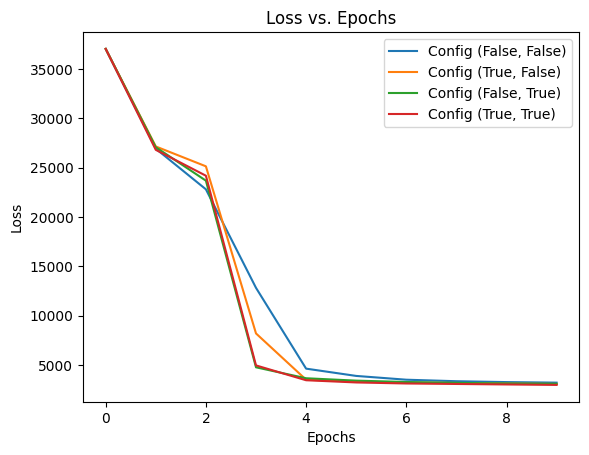

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the datasets
pm25_df = pd.read_csv('/content/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial).csv')
o3_df = pd.read_csv('/content/bihar_Cleaned_O3_interpolated(T-1)(spatial).csv')

# Prepare the input features and target variable
X_base = o3_df[['DateTime', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds
X_base['DateTime'] = pd.to_datetime(X_base['DateTime'], errors='coerce').astype('int64') // 10**9

# Custom MLP Regressor class
class CustomMLPRegressor:
    def __init__(self, hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.losses = []  # Store loss for each iteration

    def initialize_weights(self, input_size, output_size):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize weights and biases for each layer
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        activations = [X]
        zs = []

        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            activation = self.relu(z) if w is not self.weights[-1] else z  # ReLU for hidden layers, linear for output
            activations.append(activation)

        return activations, zs

    def backward(self, activations, zs, y):
        m = y.shape[0]
        deltas = [activations[-1] - y.values.reshape(-1, 1)]  # Corrected line

        # Backpropagation for hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[0], self.weights[i + 1].T) * self.relu_derivative(zs[i])
            deltas.insert(0, delta)

        # Gradient calculation
        dw = [np.dot(activations[i].T, deltas[i]) / m for i in range(len(deltas))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / m for i in range(len(deltas))]

        return dw, db

    def update_parameters(self, dw, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dw[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            if i % 100 == 0:
                loss = np.mean((activations[-1] - y.values.reshape(-1, 1))**2)  # Use y.values to convert Series to numpy array
                self.losses.append(loss)  # Store loss for plotting
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].flatten()

# Prepare different configurations
configurations = [
    {'use_t_1': False, 'use_avg_O3_nearest': False},
    {'use_t_1': True, 'use_avg_O3_nearest': False},
    {'use_t_1': False, 'use_avg_O3_nearest': True},
    {'use_t_1': True, 'use_avg_O3_nearest': True},
]

results = []

for config in configurations:
    features = ['DateTime', 'O3', 'lat', 'long']
    if config['use_t_1']:
        features.append('(t-1)')
    if config['use_avg_O3_nearest']:
        features.append('avg_O3_nearest')

    X = X_base[features].values
    y = y

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    X_train_mean, X_train_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std

    # Train the MLP model
    model = CustomMLPRegressor(hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results.append({
        'Configuration': f"use_t_1={config['use_t_1']}, use_avg_O3_nearest={config['use_avg_O3_nearest']}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
    })

    # Plot the loss vs. epochs graph
    plt.plot(model.losses, label=f"Config {config['use_t_1'], config['use_avg_O3_nearest']}")

# Display results in a table
results_df = pd.DataFrame(results)
print(results_df)

# Show loss graph
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

***Random Forest***

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the datasets
pm25_df = pd.read_csv('/content/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial).csv')
o3_df = pd.read_csv('/content/bihar_Cleaned_O3_interpolated(T-1)(spatial).csv')

# Prepare the input features and target variable
X_base = o3_df[['DateTime', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds
X_base['DateTime'] = pd.to_datetime(X_base['DateTime'], errors='coerce').astype('int64') // 10**9

# Prepare different configurations
configurations = [
    {'use_t_1': False, 'use_avg_O3_nearest': False},
    {'use_t_1': True, 'use_avg_O3_nearest': False},
    {'use_t_1': False, 'use_avg_O3_nearest': True},
    {'use_t_1': True, 'use_avg_O3_nearest': True},
]

results = []

for config in configurations:
    features = ['DateTime', 'O3', 'lat', 'long']
    if config['use_t_1']:
        features.append('(t-1)')
    if config['use_avg_O3_nearest']:
        features.append('avg_O3_nearest')

    X = X_base[features].values
    y = y
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    X_train_mean, X_train_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std

    # Train the Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results.append({
        'Configuration': f"use_t_1={config['use_t_1']}, use_avg_O3_nearest={config['use_avg_O3_nearest']}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)

<ipython-input-3-d7c975b09269>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_base['DateTime'] = pd.to_datetime(X_base['DateTime'], errors='coerce').astype('int64') // 10**9


                             Configuration         MSE        MAE        R2
0  use_t_1=False, use_avg_O3_nearest=False  675.791369  11.887562  0.976229
1   use_t_1=True, use_avg_O3_nearest=False  732.905260  13.049143  0.974220
2   use_t_1=False, use_avg_O3_nearest=True  763.769454  13.647196  0.973134
3    use_t_1=True, use_avg_O3_nearest=True  784.949836  14.176076  0.972389


**Splitting data set on basis of seasons**

In [ ]:
# Load dataset
pm25_df = pd.read_csv('/content/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial).csv')
o3_df = pd.read_csv('/content/bihar_Cleaned_O3_interpolated(T-1)(spatial).csv')

# Convert 'DateTime' column to datetime object
pm25_df['DateTime'] = pd.to_datetime(pm25_df['DateTime'])
o3_df['DateTime'] = pd.to_datetime(o3_df['DateTime'])

# Define seasons based on month
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}

# Add a 'Season' column to the dataset
def assign_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return None

pm25_df['Season'] = pm25_df['DateTime'].dt.month.apply(assign_season)
o3_df['Season'] = o3_df['DateTime'].dt.month.apply(assign_season)

# Create and save separate DataFrames for each season without the 'Season' column
for season in seasons.keys():
    season_data_pm2.5 = pm25_df[pm25_df['Season'] == season].drop(columns=['Season'])
    season_data_pm2.5.to_csv(f'bihar_Cleaned_PM2.5_interpolated(T-1)(spatial){season}.csv', index=False)
    season_data_o3 = o3_df[o3_df['Season'] == season].drop(columns=['Season'])
    season_data_o3.to_csv(f'bihar_Cleaned_O3_interpolated(T-1)(spatial){season}.csv', index=False)

***For Spring***


Iteration 0/1000, Loss: 33836.2515
Iteration 100/1000, Loss: 25598.7075
Iteration 200/1000, Loss: 16934.4652
Iteration 300/1000, Loss: 3134.7365
Iteration 400/1000, Loss: 2653.0175
Iteration 500/1000, Loss: 2471.7872
Iteration 600/1000, Loss: 2365.3157
Iteration 700/1000, Loss: 2287.5798
Iteration 800/1000, Loss: 2245.3955
Iteration 900/1000, Loss: 2193.8261


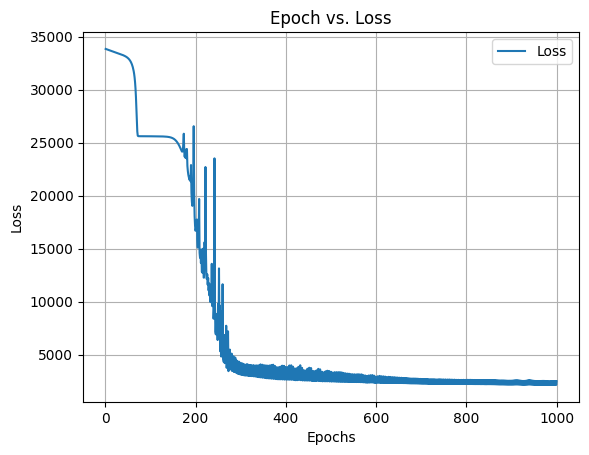

R-squared: 0.91
Mean Absolute Error: 32.31
Root Mean Squared Error: 47.09


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Modify the fit method to record losses
class CustomMLPRegressor:
    def __init__(self, hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.losses = []  # Add a list to store the loss for each epoch

    # The rest of the class remains the same...
    def initialize_weights(self, input_size, output_size):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize weights and biases for each layer
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        activations = [X]
        zs = []

        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            activation = self.relu(z) if w is not self.weights[-1] else z  # ReLU for hidden layers, linear for output
            activations.append(activation)

        return activations, zs

    def backward(self, activations, zs, y):
        m = y.shape[0]
        deltas = [activations[-1] - y.reshape(-1, 1)]  # Output error

        # Backpropagation for hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[0], self.weights[i + 1].T) * self.relu_derivative(zs[i])
            deltas.insert(0, delta)

        # Gradient calculation
        dw = [np.dot(activations[i].T, deltas[i]) / m for i in range(len(deltas))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / m for i in range(len(deltas))]

        return dw, db

    def update_parameters(self, dw, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dw[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            if i % 100 == 0:
                loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].flatten()

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            # Calculate and store the loss
            loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
            self.losses.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def plot_loss(self):
        plt.plot(range(1, self.max_iter + 1), self.losses, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epoch vs. Loss')
        plt.legend()
        plt.grid()
        plt.show()

# Load the datasets
pm25_df = pd.read_csv('/content/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial)_Spring.csv')
o3_df = pd.read_csv('/content/bihar_Cleaned_O3_interpolated(T-1)(spatial)_Spring.csv')

# Prepare the input features and target variable
X = o3_df[['DateTime', 'Stn_id', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds and handle potential errors
X['DateTime'] = pd.to_datetime(X['DateTime'], errors='coerce').astype('int64') // 10**9

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the custom MLP Regressor
mlp_reg = CustomMLPRegressor(hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train.values)

# Plot the loss graph
mlp_reg.plot_loss()

# Evaluate the model
y_pred = mlp_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation metrics
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
#for Autumn

Iteration 0/1000, Loss: 31207.5858
Iteration 100/1000, Loss: 26591.4499
Iteration 200/1000, Loss: 24652.7879
Iteration 300/1000, Loss: 2631.1225
Iteration 400/1000, Loss: 1517.2489
Iteration 500/1000, Loss: 1292.0413
Iteration 600/1000, Loss: 1239.4666
Iteration 700/1000, Loss: 1200.7863
Iteration 800/1000, Loss: 1174.0240
Iteration 900/1000, Loss: 1157.6474


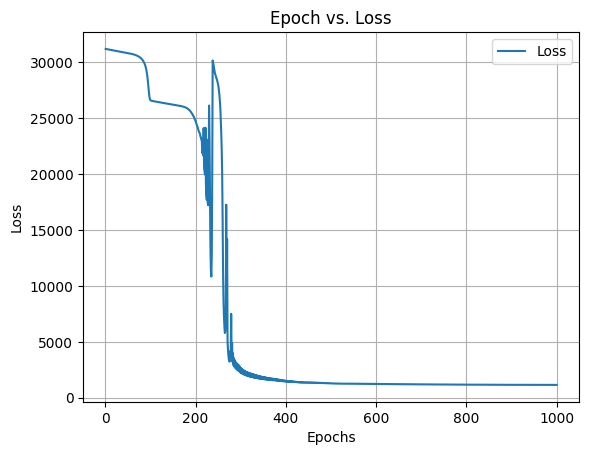

R-squared: 0.95
Mean Absolute Error: 23.25
Root Mean Squared Error: 34.51


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Modify the fit method to record losses
class CustomMLPRegressor:
    def __init__(self, hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.losses = []  # Add a list to store the loss for each epoch

    # The rest of the class remains the same...
    def initialize_weights(self, input_size, output_size):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize weights and biases for each layer
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        activations = [X]
        zs = []

        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            activation = self.relu(z) if w is not self.weights[-1] else z  # ReLU for hidden layers, linear for output
            activations.append(activation)

        return activations, zs

    def backward(self, activations, zs, y):
        m = y.shape[0]
        deltas = [activations[-1] - y.reshape(-1, 1)]  # Output error

        # Backpropagation for hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[0], self.weights[i + 1].T) * self.relu_derivative(zs[i])
            deltas.insert(0, delta)

        # Gradient calculation
        dw = [np.dot(activations[i].T, deltas[i]) / m for i in range(len(deltas))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / m for i in range(len(deltas))]

        return dw, db

    def update_parameters(self, dw, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dw[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            if i % 100 == 0:
                loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].flatten()

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            # Calculate and store the loss
            loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
            self.losses.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def plot_loss(self):
        plt.plot(range(1, self.max_iter + 1), self.losses, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epoch vs. Loss')
        plt.legend()
        plt.grid()
        plt.show()

# Load the datasets
pm25_df = pd.read_csv('/content/drive/MyDrive/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial)_Summer.csv')
o3_df = pd.read_csv('/content/drive/MyDrive/bihar_Cleaned_O3_interpolated(T-1)(spatial)_Summer.csv')

# Prepare the input features and target variable
X = o3_df[['DateTime', 'Stn_id', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds and handle potential errors
X['DateTime'] = pd.to_datetime(X['DateTime'], errors='coerce').astype('int64') // 10**9

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the custom MLP Regressor
mlp_reg = CustomMLPRegressor(hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train.values)

# Plot the loss graph
mlp_reg.plot_loss()

# Evaluate the model
y_pred = mlp_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation metrics
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Iteration 0/1000, Loss: 36429.1713
Iteration 100/1000, Loss: 26767.3506
Iteration 200/1000, Loss: 20130.1815
Iteration 300/1000, Loss: 23361.3284
Iteration 400/1000, Loss: 4255.7876
Iteration 500/1000, Loss: 2873.5421
Iteration 600/1000, Loss: 2584.1589
Iteration 700/1000, Loss: 2473.4512
Iteration 800/1000, Loss: 2400.4486
Iteration 900/1000, Loss: 2341.3030


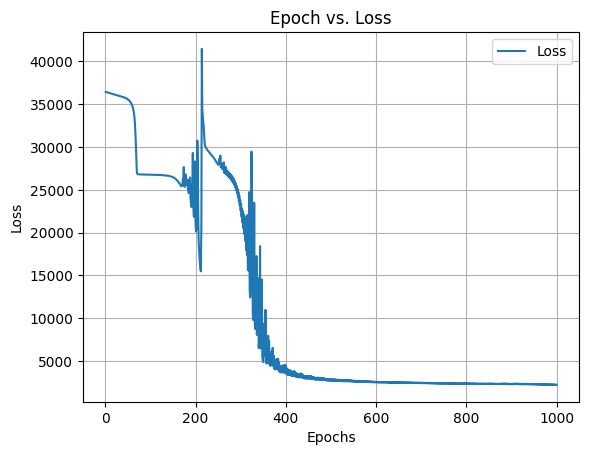

R-squared: 0.91
Mean Absolute Error: 31.81
Root Mean Squared Error: 47.41


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Modify the fit method to record losses
class CustomMLPRegressor:
    def __init__(self, hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.losses = []  # Add a list to store the loss for each epoch

    # The rest of the class remains the same...
    def initialize_weights(self, input_size, output_size):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize weights and biases for each layer
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        activations = [X]
        zs = []

        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            activation = self.relu(z) if w is not self.weights[-1] else z  # ReLU for hidden layers, linear for output
            activations.append(activation)

        return activations, zs

    def backward(self, activations, zs, y):
        m = y.shape[0]
        deltas = [activations[-1] - y.reshape(-1, 1)]  # Output error

        # Backpropagation for hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[0], self.weights[i + 1].T) * self.relu_derivative(zs[i])
            deltas.insert(0, delta)

        # Gradient calculation
        dw = [np.dot(activations[i].T, deltas[i]) / m for i in range(len(deltas))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / m for i in range(len(deltas))]

        return dw, db

    def update_parameters(self, dw, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dw[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            if i % 100 == 0:
                loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].flatten()

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            # Calculate and store the loss
            loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
            self.losses.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def plot_loss(self):
        plt.plot(range(1, self.max_iter + 1), self.losses, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epoch vs. Loss')
        plt.legend()
        plt.grid()
        plt.show()

# Load the datasets
pm25_df = pd.read_csv('/content/bihar_Cleaned_PM2.5_interpolated(T-1)(spatial)_Autumn.csv')
o3_df = pd.read_csv('/content/bihar_Cleaned_O3_interpolated(T-1)(spatial)_Autumn.csv')

# Prepare the input features and target variable
X = o3_df[['DateTime', 'Stn_id', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds and handle potential errors
X['DateTime'] = pd.to_datetime(X['DateTime'], errors='coerce').astype('int64') // 10**9

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the custom MLP Regressor
mlp_reg = CustomMLPRegressor(hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train.values)

# Plot the loss graph
mlp_reg.plot_loss()

# Evaluate the model
y_pred = mlp_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation metrics
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
# winter

Iteration 0/1000, Loss: 48004.5016
Iteration 100/1000, Loss: 26388.5251
Iteration 200/1000, Loss: 27386.3244
Iteration 300/1000, Loss: 16541.2135
Iteration 400/1000, Loss: 6268.1746
Iteration 500/1000, Loss: 5952.4454
Iteration 600/1000, Loss: 5757.6652
Iteration 700/1000, Loss: 5618.9550
Iteration 800/1000, Loss: 5515.1502
Iteration 900/1000, Loss: 5415.2658


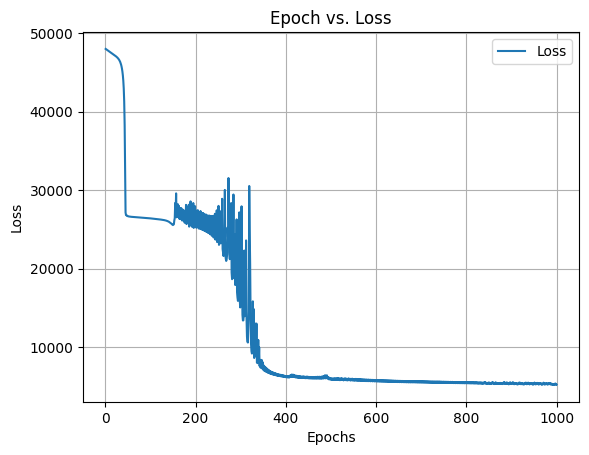

R-squared: 0.81
Mean Absolute Error: 49.92
Root Mean Squared Error: 73.91


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Modify the fit method to record losses
class CustomMLPRegressor:
    def __init__(self, hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.weights = []
        self.biases = []
        self.losses = []  # Add a list to store the loss for each epoch

    # The rest of the class remains the same...
    def initialize_weights(self, input_size, output_size):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize weights and biases for each layer
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        activations = [X]
        zs = []

        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            activation = self.relu(z) if w is not self.weights[-1] else z  # ReLU for hidden layers, linear for output
            activations.append(activation)

        return activations, zs

    def backward(self, activations, zs, y):
        m = y.shape[0]
        deltas = [activations[-1] - y.reshape(-1, 1)]  # Output error

        # Backpropagation for hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[0], self.weights[i + 1].T) * self.relu_derivative(zs[i])
            deltas.insert(0, delta)

        # Gradient calculation
        dw = [np.dot(activations[i].T, deltas[i]) / m for i in range(len(deltas))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / m for i in range(len(deltas))]

        return dw, db

    def update_parameters(self, dw, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dw[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            if i % 100 == 0:
                loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].flatten()

    def fit(self, X, y):
        input_size = X.shape[1]
        output_size = 1  # Single output for regression
        self.initialize_weights(input_size, output_size)

        for i in range(self.max_iter):
            activations, zs = self.forward(X)
            dw, db = self.backward(activations, zs, y)
            self.update_parameters(dw, db)

            # Calculate and store the loss
            loss = np.mean((activations[-1] - y.reshape(-1, 1))**2)
            self.losses.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}/{self.max_iter}, Loss: {loss:.4f}")

    def plot_loss(self):
        plt.plot(range(1, self.max_iter + 1), self.losses, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Epoch vs. Loss')
        plt.legend()
        plt.grid()
        plt.show()

# Load the datasets
pm25_df = pd.read_csv('bihar_Cleaned_PM2.5_interpolated(T-1)(spatial)_Winter.csv')
o3_df = pd.read_csv('bihar_Cleaned_O3_interpolated(T-1)(spatial)_Winter.csv')

# Prepare the input features and target variable
X = o3_df[['DateTime', 'Stn_id', 'O3', 'lat', 'long', '(t-1)', 'avg_O3_nearest']]
y = pm25_df['Pm2.5']

# Convert DateTime to seconds and handle potential errors
X['DateTime'] = pd.to_datetime(X['DateTime'], errors='coerce').astype('int64') // 10**9

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the custom MLP Regressor
mlp_reg = CustomMLPRegressor(hidden_layer_sizes=(100, 50), learning_rate=0.001, max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train.values)

# Plot the loss graph
mlp_reg.plot_loss()

# Evaluate the model
y_pred = mlp_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation metrics
print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')